In [1]:
import numpy as np
import matplotlib.pyplot as plt

%run ./split_step_fourier.ipynb

DEBUG = True

# showing figures inline
%matplotlib inline
# plotting options 
figure_size = (16, 9)
plt.rcParams.update({
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

Text(0.5, 1.0, 'Impulse Responses')

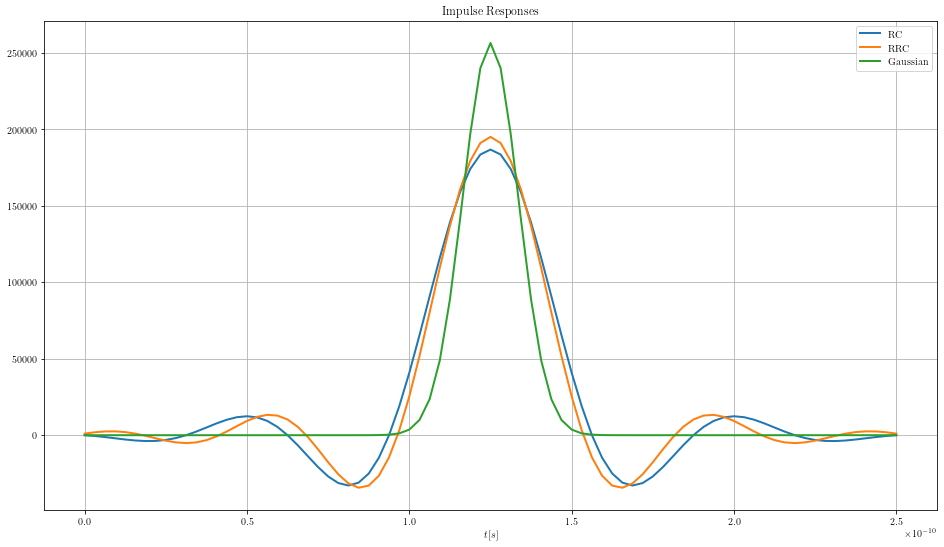

In [2]:
# parameters of the filters
f_symbol = 32e9  # symbol rate (Baud) (Symbols per second)
n_up = 10  # samples per symbol (>1 => oversampling)

r_rc = .33
r_rrc = .33

syms_per_filt = 4  # symbols per filter (plus minus in both directions)

t_sample_rc, rc = get_rc_ir(syms_per_filt, r_rc, f_symbol, n_up)
t_sample_rrc, rrc = get_rrc_ir(syms_per_filt, r_rrc, f_symbol, n_up)
t_sample_gaussian, gaussian = get_gaussian_ir(syms_per_filt, 0.99, f_symbol, n_up)

fig1 = plt.figure(figsize=figure_size)
sbplt11 = fig1.add_subplot(111)
rc_plt, = sbplt11.plot(np.arange(rc.size)*t_sample_rc, rc, linewidth=2.0, label='RC')
rrc_plt, = sbplt11.plot(np.arange(rrc.size)*t_sample_rrc, rrc, linewidth=2.0, label='RRC')
gauss_plt, = sbplt11.plot(np.arange(gaussian.size)*t_sample_gaussian, gaussian, linewidth=2.0, label='Gaussian')

sbplt11.grid( True )
sbplt11.legend( loc='upper right' )
sbplt11.set_xlabel('$t[s]$')
sbplt11.set_title( 'Impulse Responses' )

Text(0.5, 1.0, 'Impulse Responses')

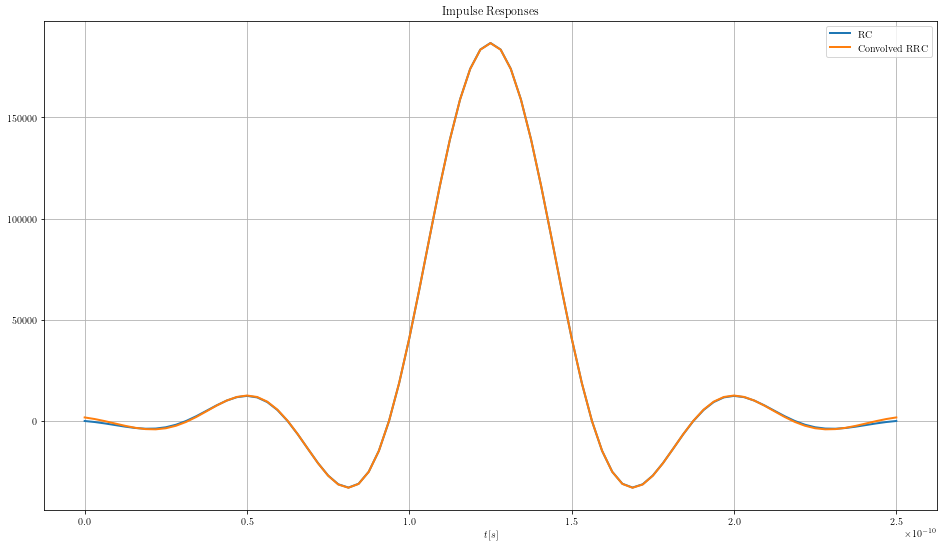

In [3]:
# Comparison of convolved rrc with rc

t_rc, rc = get_rc_ir(syms_per_filt, r_rc, f_symbol, n_up)
t_rrc, rrc = get_rrc_ir(syms_per_filt, r_rrc, f_symbol, n_up)

rrc_convolved = np.convolve(rrc, rrc, mode='same')
rrc_convolved /= np.linalg.norm(rrc_convolved) * np.sqrt(t_rrc)

fig2 = plt.figure(figsize=figure_size)
sbplt21 = fig2.add_subplot(111)
sbplt21.plot(np.arange(rc.size)*t_sample_rc, rc , linewidth=2.0, label='RC')
sbplt21.plot(np.arange(rrc_convolved.size)*t_sample_rrc, rrc_convolved, linewidth=2.0, label='Convolved RRC')

sbplt21.grid( True )
sbplt21.legend(loc='upper right')
sbplt21.set_xlabel('$t[s]$')
sbplt21.set_title('Impulse Responses')


Power before amplification: 319999999999.9999 W (145.05149978319906 dBm)
Power target value: 0.07943282347242814 W (19.0 dBm)
Power after amplification: 0.07943282347242817 W (19.0 dBm)
Power before amplification: 320000000000.00006 W (145.05149978319906 dBm)
Power target value: 0.07943282347242814 W (19.0 dBm)
Power after amplification: 0.07943282347242812 W (19.0 dBm)
Power before amplification: 319999999999.9999 W (145.05149978319906 dBm)
Power target value: 0.07943282347242814 W (19.0 dBm)
Power after amplification: 0.07943282347242814 W (19.0 dBm)


/home/dominik/.virtualenvs/jupyterlab/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0.5, 1.0, 'Modulation Gaus')

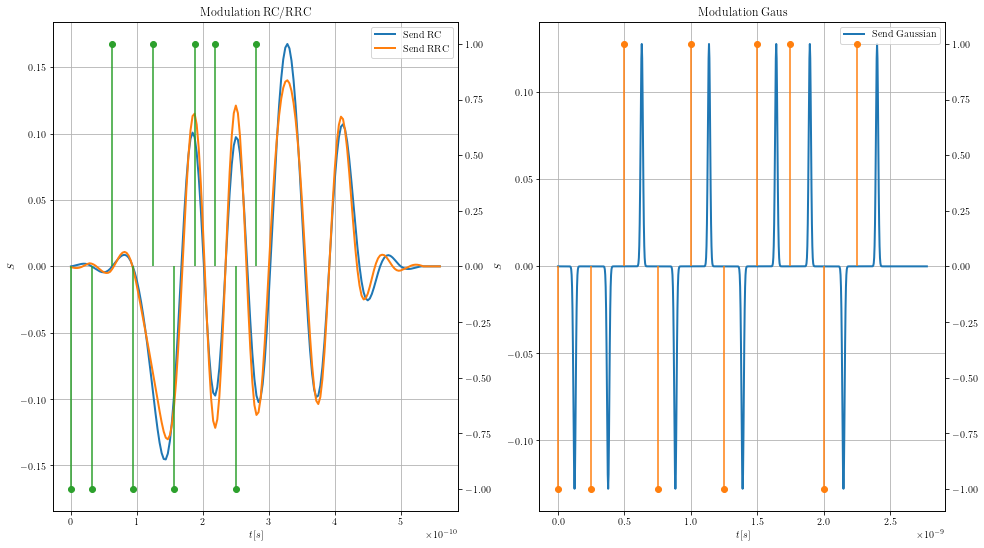

In [4]:
# modulation scheme and constellation points
M = 2
modulation = {'0': -1, '1': 1}
n_symbol = 10 # number of symbols

P_in = 19  # Send Power in [dBm]

# Signalfolge generieren
send_bits = np.random.choice([symbol for symbol in modulation.keys()], size=n_symbol)

send_rc = generate_signal(modulation, t_sample_rc, 1/f_symbol, send_bits, rc, syms_per_filt, P_in)
send_rrc = generate_signal(modulation, t_sample_rrc, 1/f_symbol, send_bits, rrc, syms_per_filt, P_in)
send_gaussian = generate_signal(modulation, t_sample_gaussian, 1/f_symbol, send_bits, gaussian, 0, P_in)

fig3, ax3 = plt.subplots(1,2, figsize=figure_size)

ax3[0].plot(np.arange(send_rc.size)*t_sample_rc, send_rc, linewidth=2.0, label='Send RC')
ax3[0].plot(np.arange(send_rrc.size)*t_sample_rrc, send_rrc, linewidth=2.0, label='Send RRC')
ax31 = ax3[0].twinx()
ax31.stem(np.arange(len(send_bits)/f_symbol, step=1/f_symbol), [ modulation[str(symbol)] for symbol in send_bits ], label='Send symbols', use_line_collection=True, basefmt=' ', linefmt='C2', markerfmt='C2o')

ax3[0].grid( True )
ax3[0].legend(loc='upper right')
ax3[0].set_ylabel('$S$')
ax3[0].set_xlabel('$t[s]$')
ax3[0].set_title('Modulation RC/RRC')
max_value = np.amax(np.abs(np.concatenate((send_rc, send_rrc))))
ax3[0].set_ylim(-1.1*max_value, 1.1*max_value)

ax3[1].plot(np.arange(send_gaussian.size)*t_sample_gaussian, send_gaussian, linewidth=2.0, label='Send Gaussian')
ax32 = ax3[1].twinx()
ax32.stem(np.arange(2*syms_per_filt*n_symbol/f_symbol, step=2*syms_per_filt/f_symbol), [ modulation[str(symbol)] for symbol in send_bits ], label='Send symbols', use_line_collection=True, basefmt=' ', linefmt='C1', markerfmt='C1o')

ax3[1].grid( True )
ax3[1].legend(loc='upper right')
ax3[1].set_ylabel('$S$')
ax3[1].set_xlabel('$t[s]$')
ax3[1].set_title('Modulation Gaus')

0.046051116739580934


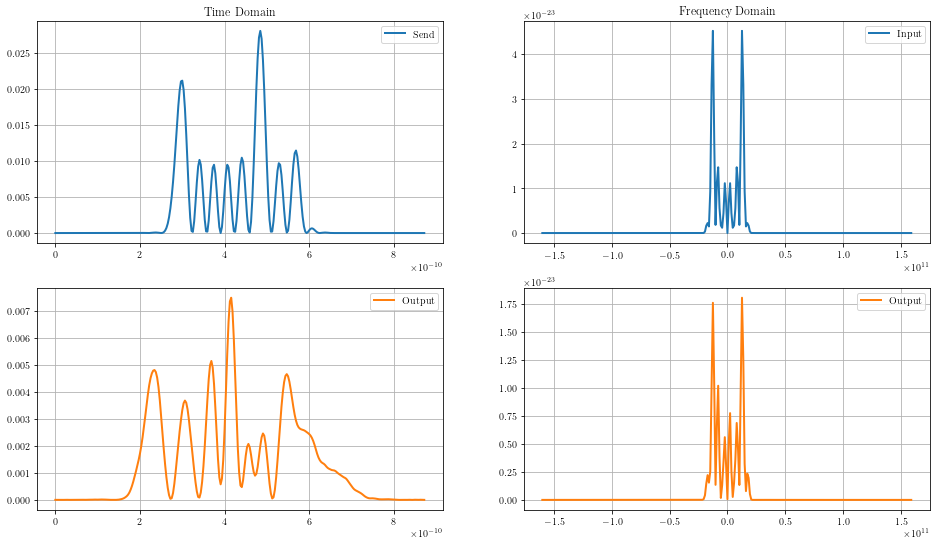

In [15]:
# Transmission
z_length = 70  # [km]
nz = 10  # steps
dz = z_length / nz  # [km]

alpha = 0.2 # Dämpfung [dB/km]
alpha_neu = alpha/4.343
print(alpha_neu)
D = 17  # [ps/nm/km]
beta2 = - (D * np.square(1550e-9)) / (2 * np.pi * 3e8) * 1e-3 # [s^2/km] propagation constant, lambda=1550nm is standard single-mode wavelength
gamma = 1.3 # [1/W/km]

send = zeroing(send_rc, 5 * int(1/f_symbol/t_sample_rc))

output = splitstepfourier(send, t_sample_rc, int(z_length/10), 10, alpha_neu, beta2, gamma)

fig4, ax4 = plt.subplots(2,2, figsize=figure_size)

ax4[0][0].plot(np.arange(send.size)*t_sample_rc, np.square(abs(send)), linewidth=2.0, label='Send')
ax4[0][0].grid(True)
ax4[0][0].set_title('Time Domain')
ax4[0][0].legend(loc='upper right')

ax4[1][0].plot(np.arange(output.size)*t_sample_rc, np.square(abs(output)), linewidth=2.0, label='Output', color='tab:orange')
ax4[1][0].grid(True)
ax4[1][0].legend(loc='upper right')

ax4[0][1].plot(np.fft.fftshift(np.fft.fftfreq(len(send),t_sample_rc)), np.fft.fftshift(np.square(abs(t_sample_rc*np.fft.fft(send)/np.sqrt(2*np.pi)))), linewidth=2.0, label='Input')
ax4[0][1].grid(True)
ax4[0][1].set_title('Frequency Domain')
ax4[0][1].legend(loc='upper right')

ax4[1][1].plot(np.fft.fftshift(np.fft.fftfreq(len(output),t_sample_rc)), np.fft.fftshift(np.square(abs(t_sample_rc*np.fft.fft(output)/np.sqrt(2*np.pi)))), linewidth=2.0, label='Output', color='tab:orange')
ax4[1][1].grid(True)
ax4[1][1].legend(loc='upper right')